float32 (240, 3, 512, 512) 0.0 5.727438 0.30981565


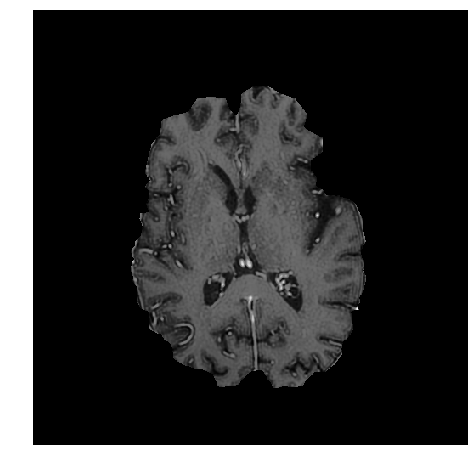

In [31]:
%reload_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

plt.set_cmap('afmhot')
plt.rcParams['figure.figsize'] = (10, 8)

import subtle.subtle_dnn as sudnn
import subtle.subtle_io as suio
import subtle.subtle_generator as sugen
import subtle.subtle_loss as suloss
import subtle.subtle_plot as suplot
import subtle.subtle_preprocess as supre
import subtle.subtle_metrics as sumetrics

from keras.optimizers import Adam

from keract import get_activations, display_activations, display_heatmaps
from keras.utils.vis_utils import plot_model
def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

plt.set_cmap('gray')

h5_file = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0109.h5'
study_h5 = h5py.File(h5_file)
study_data = np.array(study_h5['data_mask'])
study_h5.close()

print(study_data.dtype, study_data.shape, study_data.min(), study_data.max(), study_data.mean())
show_img(study_data[120, 2, :, :])

In [41]:
sudnn.clear_keras_memory()
sudnn.set_keras_memory(1.0)

loss_function = suloss.mixed_loss(l1_lambda=1.0, ssim_lambda=0.0)
metrics_monitor = [suloss.l1_loss, suloss.ssim_loss, suloss.mse_loss]

model = sudnn.DeepEncoderDecoder2D(
            num_channel_input=10, num_channel_output=1,
            img_rows=512, img_cols=512,
            num_channel_first=32,
            loss_function=loss_function,
            metrics_monitor=metrics_monitor,
            lr_init=0.001,
            batch_norm=0,
            verbose=2,
            checkpoint_file='/home/srivathsa/projects/studies/gad/stanford/train/checkpoints/512mpr_fsl.checkpoint')


model.load_weights()

build model linear
Tensor("input_1:0", shape=(?, 512, 512, 10), dtype=float32)
Tensor("conv2d_3/Relu:0", shape=(?, 512, 512, 32), dtype=float32) Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 256, 256, 32), dtype=float32)
Tensor("conv2d_6/Relu:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("conv2d_9/Relu:0", shape=(?, 128, 128, 128), dtype=float32) Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("add_1/add:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("conv2d_13/Relu:0", shape=(?, 128, 128, 128), dtype=float32) Tensor("concatenate_1/concat:0", shape=(?, 128, 128, 256), dtype=float32)
Tensor("conv2d_16/Relu:0", shape=(?, 256, 256, 64), dtype=float32) Tensor("concatenate_2/concat:0", shape=(?, 256, 256, 192), dtype=float32)
Tensor("conv2d_19/Relu:0", shape=(?, 512, 512, 32), dtype=float32) Tensor("concatenate_3/concat:0", shape=(?, 512, 512, 96), dtype=float32)
Tensor("con

In [42]:
prediction_generator = sugen.DataGenerator(
    data_list=[h5_file],
    batch_size=1,
    shuffle=False,
    verbose=0,
    residual_mode=False,
    slices_per_input=5,
    resize=512,
    slice_axis=0,
    brain_only=True,
    brain_only_mode='pure'
)

gen info float32 (512, 512) 0.0 2.7396812 0.43518886


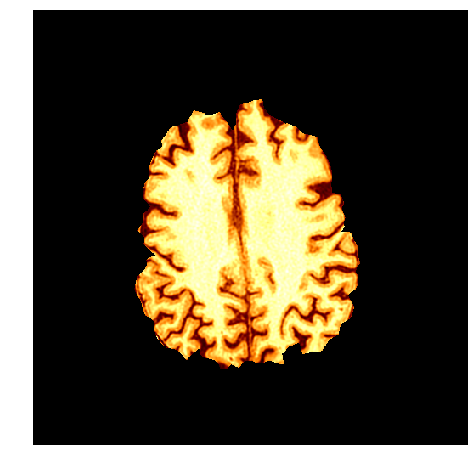

In [43]:
gen_item = prediction_generator.__getitem__(175)[0]
gen_slice = gen_item[0, :, :, 2]
print('gen info', gen_slice.dtype, gen_slice.shape, gen_slice.min(), gen_slice.max(), gen_slice.mean())
show_img(gen_slice)

In [44]:
y_pred = model.model.predict_generator(
    generator=prediction_generator,
    max_queue_size=16,
    workers=1,
    use_multiprocessing=False,
    verbose=0
)

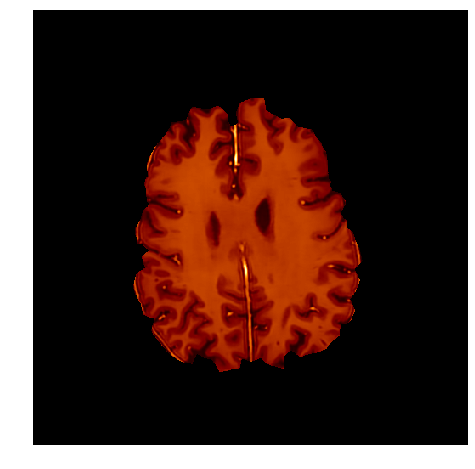

In [45]:
show_img(y_pred[168, :, :, 0])

In [46]:
net_ip = np.transpose(np.concatenate([study_data[166:171, 0], study_data[166:171, 1]]), (1, 2, 0))
net_ip = np.array([net_ip])

layer_names = [l.name for l in model.model.layers]

activations = get_activations(model.model, net_ip)
activations = sorted(activations.items(), key=lambda act: layer_names.index(act[0].split(':')[0].split('/')[0]))

for act in activations:
    print(act[0], act[1].shape)

input_1:0 (512, 512, 10)
conv2d_1/Relu:0 (1, 512, 512, 32)
conv2d_2/Relu:0 (1, 512, 512, 32)
conv2d_3/Relu:0 (1, 512, 512, 32)
max_pooling2d_1/MaxPool:0 (1, 256, 256, 32)
conv2d_4/Relu:0 (1, 256, 256, 64)
conv2d_5/Relu:0 (1, 256, 256, 64)
conv2d_6/Relu:0 (1, 256, 256, 64)
max_pooling2d_2/MaxPool:0 (1, 128, 128, 64)
conv2d_7/Relu:0 (1, 128, 128, 128)
conv2d_8/Relu:0 (1, 128, 128, 128)
conv2d_9/Relu:0 (1, 128, 128, 128)
max_pooling2d_3/MaxPool:0 (1, 64, 64, 128)
conv2d_10/Relu:0 (1, 64, 64, 128)
add_1/add:0 (1, 64, 64, 128)
up_sampling2d_1/ResizeNearestNeighbor:0 (1, 128, 128, 128)
concatenate_1/concat:0 (1, 128, 128, 256)
conv2d_11/Relu:0 (1, 128, 128, 128)
conv2d_12/Relu:0 (1, 128, 128, 128)
conv2d_13/Relu:0 (1, 128, 128, 128)
up_sampling2d_2/ResizeNearestNeighbor:0 (1, 256, 256, 128)
concatenate_2/concat:0 (1, 256, 256, 192)
conv2d_14/Relu:0 (1, 256, 256, 64)
conv2d_15/Relu:0 (1, 256, 256, 64)
conv2d_16/Relu:0 (1, 256, 256, 64)
up_sampling2d_3/ResizeNearestNeighbor:0 (1, 512, 512, 64)

In [47]:
act_subset = []
keywords = ['max_pooling', 'up_sampling', 'conv2d_19']
for layer_name, activation in activations:
    kw_exists = np.sum([1 if kw in layer_name else 0 for kw in keywords]) > 0
    if kw_exists:
        print(layer_name, activation.shape)
        act_subset.append({layer_name: activation})

max_pooling2d_1/MaxPool:0 (1, 256, 256, 32)
max_pooling2d_2/MaxPool:0 (1, 128, 128, 64)
max_pooling2d_3/MaxPool:0 (1, 64, 64, 128)
up_sampling2d_1/ResizeNearestNeighbor:0 (1, 128, 128, 128)
up_sampling2d_2/ResizeNearestNeighbor:0 (1, 256, 256, 128)
up_sampling2d_3/ResizeNearestNeighbor:0 (1, 512, 512, 64)
conv2d_19/Relu:0 (1, 512, 512, 32)


In [48]:
act_idx = 0
key = list(act_subset[act_idx].keys())[0]
activ_0 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_0[:, :, idx], title=key)

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

In [40]:
act_idx = 1
key = list(act_subset[act_idx].keys())[0]
activ_1 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_1[:, :, idx], title=key)

interactive(children=(IntSlider(value=31, description='idx', max=63), Output()), _dom_classes=('widget-interac…

In [20]:
act_idx = 2
key = list(act_subset[act_idx].keys())[0]
activ_2 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_2[:, :, idx], title=key)

interactive(children=(IntSlider(value=63, description='idx', max=127), Output()), _dom_classes=('widget-intera…

In [21]:
act_idx = 3
key = list(act_subset[act_idx].keys())[0]
activ_3 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_3[:, :, idx], title=key)

interactive(children=(IntSlider(value=63, description='idx', max=127), Output()), _dom_classes=('widget-intera…

In [22]:
act_idx = 4
key = list(act_subset[act_idx].keys())[0]
activ_4 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 127, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_4[:, :, idx], title=key)

interactive(children=(IntSlider(value=63, description='idx', max=127), Output()), _dom_classes=('widget-intera…

In [41]:
act_idx = 5
key = list(act_subset[act_idx].keys())[0]
activ_5 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 63, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_5[:, :, idx], title=key)

interactive(children=(IntSlider(value=31, description='idx', max=63), Output()), _dom_classes=('widget-interac…

In [42]:
act_idx = 6
key = list(act_subset[act_idx].keys())[0]
activ_6 = act_subset[act_idx][key][0]

@interact
def show_act(idx=(0, 31, 1)):
    plt.set_cmap('afmhot')
    show_img(activ_6[:, :, idx], title=key)

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

max_pooling2d_2/MaxPool:0 (1, 128, 128, 64) 


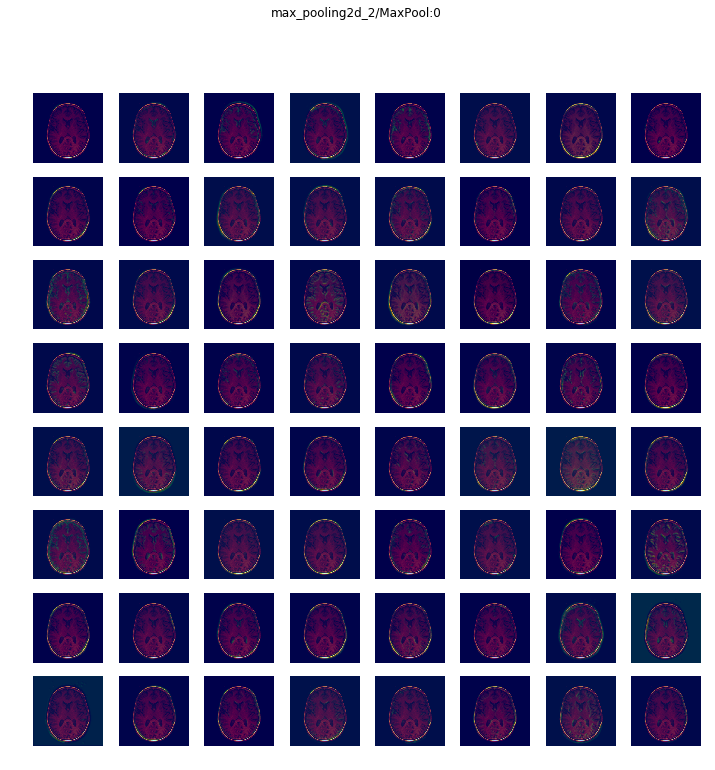

In [16]:
display_heatmaps(act_subset[1], study_data[168, 2])

conv2d_19/Relu:0 (1, 512, 512, 32) 


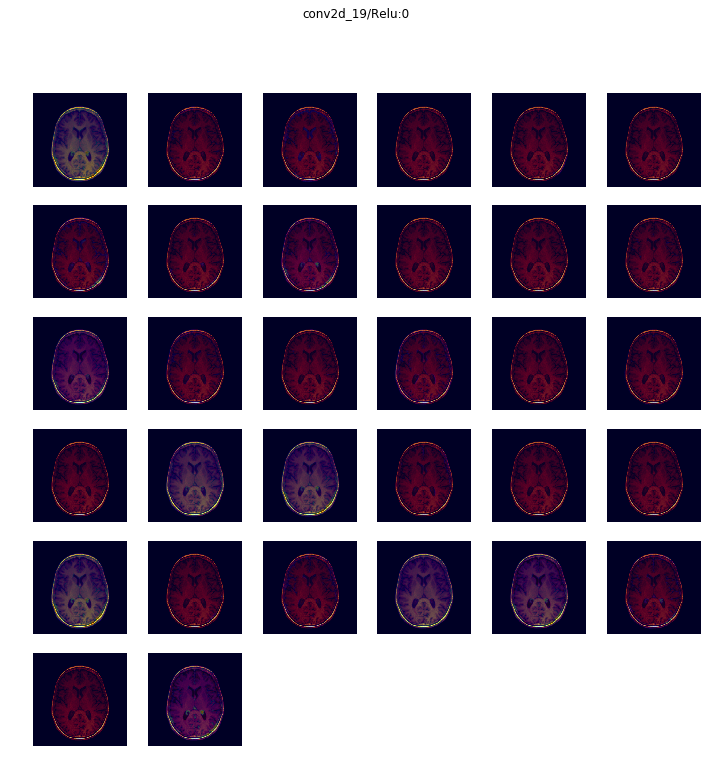

In [17]:
display_heatmaps(act_subset[6], study_data[168, 2])